In [1]:
from keras import layers
import keras
import keras.backend as K

Using TensorFlow backend.


# Models

In [0]:
width = 64
height = 64
channels = 1

## Generators Encoder


In [3]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

# Encoder
x = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', kernel_regularizer = 'l2')(input_layer)
x = layers.LeakyReLU(name='leaky_1')(x)

x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='conv_2', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_1')(x)
x = layers.LeakyReLU(name='leaky_2')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_3', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_2')(x)
x = layers.LeakyReLU(name='leaky_3')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_3')(x)
x = layers.LeakyReLU(name='leaky_4')(x)

x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

g_e = keras.models.Model(inputs=input_layer, outputs=x)

g_e.summary()

W0728 16:13:31.823398 140684485244800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 16:13:31.837861 140684485244800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 16:13:31.877521 140684485244800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 16:13:31.878358 140684485244800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0728 16:13:31.880104 140684485

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
leaky_1 (LeakyReLU)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_2 (LeakyReLU)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 16, 128)       73856     
__________

## Generator

In [4]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

x = g_e(input_layer)

y = layers.Dense(width * width * 2, name='dense')(x) # 2 = 128 / 8 / 8
y = layers.Reshape((width//8, width//8, 128), name='de_reshape')(y)

y = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', name='deconv_1', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_1')(y)

y = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', name='deconv_2', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_2')(y)

y = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', name='deconv_3', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_3')(y)

y = layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', name='decoder_deconv_output', kernel_regularizer = 'l2', activation='tanh')(y)

g = keras.models.Model(inputs=input_layer, outputs=y)

g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 128)               242048    
_________________________________________________________________
dense (Dense)                (None, 8192)              1056768   
_________________________________________________________________
de_reshape (Reshape)         (None, 8, 8, 128)         0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 16, 16, 128)       147584    
_________________________________________________________________
de_leaky_1 (LeakyReLU)       (None, 16, 16, 128)       0         
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 32, 32, 64)        73792     
__________

## Encoder

In [5]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

z = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='encoder_conv_1', kernel_regularizer = 'l2')(input_layer)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='encoder_conv_2', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_1')(z)
z = layers.LeakyReLU()(z)


z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='encoder_conv_3', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_2')(z)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_41', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_3')(z)
z = layers.LeakyReLU()(z)

z = layers.GlobalAveragePooling2D(name='encoder_output')(z)

encoder = keras.models.Model(input_layer, z)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 64, 64, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 32, 32, 64)        18496     
_________________________________________________________________
encoder_norm_1 (BatchNormali (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 16, 16, 128)       73856     
__________

## feature extractor

In [6]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

f = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='f_conv_1', kernel_regularizer = 'l2')(input_layer)
f = layers.LeakyReLU(name='f_leaky_1')(f)

f = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='f_conv_2', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_1')(f)
f = layers.LeakyReLU(name='f_leaky_2')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_3', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_2')(f)
f = layers.LeakyReLU(name='f_leaky_3')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_4', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_3')(f)
f = layers.LeakyReLU(name='feature_output')(f)

feature_extractor = keras.models.Model(input_layer, f)

feature_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
f_conv_1 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
f_leaky_1 (LeakyReLU)        (None, 64, 64, 32)        0         
_________________________________________________________________
f_conv_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
f_norm_1 (BatchNormalization (None, 32, 32, 64)        256       
_________________________________________________________________
f_leaky_2 (LeakyReLU)        (None, 32, 32, 64)        0         
_________________________________________________________________
f_conv_3 (Conv2D)            (None, 16, 16, 128)       73856     
__________

## gan trainer

In [7]:
class AdvLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdvLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori_feature = feature_extractor(x[0])
        gan_feature = feature_extractor(x[1])
        return K.mean(K.square(ori_feature - K.mean(gan_feature, axis=0)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class CntLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CntLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.abs(ori - gan))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class EncLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(g_e(ori) - encoder(gan)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
# model for training
input_layer = layers.Input(name='input', shape=(height, width, channels))
gan = g(input_layer) # g(x)

adv_loss = AdvLoss(name='adv_loss')([input_layer, gan])
cnt_loss = CntLoss(name='cnt_loss')([input_layer, gan])
enc_loss = EncLoss(name='enc_loss')([input_layer, gan])

gan_trainer = keras.models.Model(input_layer, [adv_loss, cnt_loss, enc_loss])

# loss function
def loss(yt, yp):
    return yp

losses = {
    'adv_loss': loss,
    'cnt_loss': loss,
    'enc_loss': loss,
}

lossWeights = {'cnt_loss': 20.0, 'adv_loss': 1.0, 'enc_loss': 1.0}

# compile
gan_trainer.compile(optimizer = 'adam', loss=losses, loss_weights=lossWeights)

W0728 16:13:34.669180 140684485244800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [8]:
gan_trainer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 64, 64, 1)    1538689     input[0][0]                      
__________________________________________________________________________________________________
adv_loss (AdvLoss)              [(None, 64, 64, 1),  0           input[0][0]                      
                                                                 model_2[1][0]                    
__________________________________________________________________________________________________
cnt_loss (CntLoss)              [(None, 64, 64, 1),  0           input[0][0]                      
          

## discriminator

In [9]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

f = feature_extractor(input_layer)

d = layers.GlobalAveragePooling2D(name='glb_avg')(f)
d = layers.Dense(1, activation='sigmoid', name='d_out')(d)
    
d = keras.models.Model(input_layer, d)
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
model_4 (Model)              (None, 8, 8, 128)         242048    
_________________________________________________________________
glb_avg (GlobalAveragePoolin (None, 128)               0         
_________________________________________________________________
d_out (Dense)                (None, 1)                 129       
Total params: 242,177
Trainable params: 241,537
Non-trainable params: 640
_________________________________________________________________


In [10]:
d.compile(optimizer='adam', loss='binary_crossentropy')

W0728 16:13:34.961086 140684485244800 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Load Data

In [0]:
from keras.datasets import mnist
import cv2
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_ok = x_train[y_train == 1] # 6742 筆
x_test = x_test[(y_test == 7) | (y_test == 1)] # 1135 筆 "1", 1028 筆 "7"
y_test = y_test[(y_test == 7) | (y_test == 1)]

def reshape_x(x):
    new_x = np.empty((len(x), width, height))
    for i, e in enumerate(x):
        new_x[i] = cv2.resize(e, (width, height))
    return np.expand_dims(new_x, axis=-1) / 127 - 1
  
x_ok = reshape_x(x_ok)
x_test = reshape_x(x_test)

In [12]:
x_ok.max()

1.0078740157480315

# Training

In [0]:
niter = 1000
bz = 32

In [0]:
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]

In [0]:
train_data_generator = get_data_generator(x_ok, bz)

In [16]:
for i in range(niter):
    
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
        
    ### train disciminator ###
    d.trainable = True
        
    fake_x = g.predict(x)
        
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
        
    d_loss = d.train_on_batch(d_x, d_y)

    ### train generator ###
    
    d.trainable = False        
    g_loss = gan_trainer.train_on_batch(x, y)
    
    if i % 50 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

niter: 1, g_loss: [25.06403, 0.8622211, 0.9520195, 0.0061027515], d_loss: 3.427579402923584
niter: 51, g_loss: [3.7378323, 0.20746255, 0.087352656, 0.013825074], d_loss: 1.4740113019943237
niter: 101, g_loss: [2.7006092, 0.3273732, 0.074232236, 0.032643713], d_loss: 0.6889151930809021
niter: 151, g_loss: [2.0983763, 0.20837095, 0.06450798, 0.035917286], d_loss: 0.3874967098236084
niter: 201, g_loss: [1.942549, 0.32823795, 0.058164723, 0.03201071], d_loss: 0.25401929020881653
niter: 251, g_loss: [1.6400294, 0.2762037, 0.04925046, 0.03459087], d_loss: 0.2448771893978119
niter: 301, g_loss: [1.7351533, 0.41942966, 0.049196772, 0.025891107], d_loss: 0.2044672966003418
niter: 351, g_loss: [1.6054927, 0.37932116, 0.045916416, 0.032005716], d_loss: 0.32580500841140747
niter: 401, g_loss: [1.4726269, 0.30067146, 0.045088183, 0.025800236], d_loss: 0.20574723184108734
niter: 451, g_loss: [2.0226114, 0.67314136, 0.05410832, 0.02569195], d_loss: 0.27661558985710144
niter: 501, g_loss: [1.6077963, 

KeyboardInterrupt: ignored

# Evaluation

In [0]:
encoded = g_e.predict(x_test)
gan_x = g.predict(x_test)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

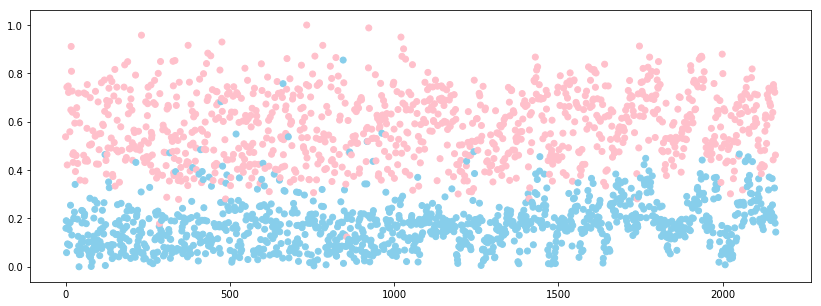

In [18]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(x_test)), score, c=['skyblue' if x == 1 else 'pink' for x in y_test])


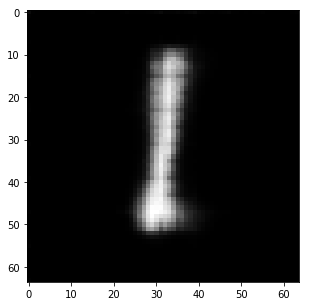

In [19]:
i = 4 # or 1
image = np.reshape(gan_x[i:i+1], (64, 64))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')

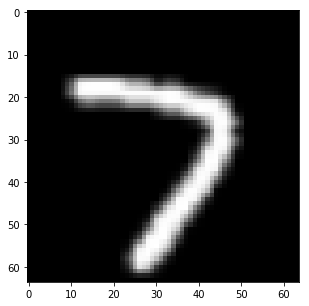

In [20]:
image = np.reshape(x_test[i:i+1], (64, 64))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')